we’ll first write a function named explore_data()
 that we can use repeatedly to explore rows in a more readable way. We’ll also add an option for our function to show the number of rows and columns for any data set.

In [23]:
def explore_data(dataset, start, end, rows_and_columns=False):
    dataset_slice = dataset[start:end]    
    for row in dataset_slice:
        print(row)
        print('n') 
    if rows_and_columns:
        print('Number of rows:', len(dataset))
        print('Number of columns:', len(dataset[0]))

Collecting data for over four million apps requires a significant amount of time and money, so we’ll try to analyze a sample of data instead. To avoid spending resources with collecting new data ourselves, we should first try to see whether we can find any relevant existing data at no cost. Luckily, these are two data sets that seem suitable for our purpose:

A data set containing data about approximately ten thousand Android apps from Google Play
A data set containing data about approximately seven thousand iOS apps from the App Store

In [24]:
from csv import reader

### The Google Play data set ###
opened_file = open('googleplaystore.csv', encoding="cp437", errors='ignore')
read_file = reader(opened_file)
android = list(read_file)
android_header = android[0]
android = android[1:]

### The App Store data set ###
opened_file = open('AppleStore.csv', encoding="cp437", errors='ignore')
read_file = reader(opened_file)
ios = list(read_file)
ios_header = ios[0]
ios = ios[1:]



Cleaning the Data
The Google Play data set has a dedicated discussion section, and we can see that one of the discussions outlines an error for row 10472. Let’s print this row and compare it against the header and another row that is correct.

In [25]:
print(android[10472])  # incorrect row
print('n')
print(android_header)  # header
print('n')
print(android[0])      # correct row

['Life Made WI-Fi Touchscreen Photo Frame', '1.9', '19', '3.0M', '1,000+', 'Free', '0', 'Everyone', '', 'February 11, 2018', '1.0.19', '4.0 and up']
n
['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
n
['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']


In [26]:
print(ios_header)
print('n')
explore_data(ios, 0, 3, True)

['', 'id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']
n
['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1']
n
['2', '281796108', 'Evernote - stay organized', '158578688', 'USD', '0', '161065', '26', '4', '3.5', '8.2.2', '4+', 'Productivity', '37', '5', '23', '1']
n
['3', '281940292', 'WeatherBug - Local Weather, Radar, Maps, Alerts', '100524032', 'USD', '0', '188583', '2822', '3.5', '4.5', '5.0.0', '4+', 'Weather', '37', '5', '3', '1']
n
Number of rows: 7197
Number of columns: 17


Removing Duplicate Entries
If we explore the Google Play data set long enough, we’ll find that some apps have more than one entry. For instance, the application Instagram has four entries:

In [27]:
for app in android:
    name = app[0]
    if name == 'Instagram':
        print(app)

['Instagram', 'SOCIAL', '4.5', '66577313', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66577446', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66577313', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']
['Instagram', 'SOCIAL', '4.5', '66509917', 'Varies with device', '1,000,000,000+', 'Free', '0', 'Teen', 'Social', 'July 31, 2018', 'Varies with device', 'Varies with device']


In [28]:
### Counting the duplicate apps ###
duplicate_apps = []
unique_apps = []

for app in android:
    name = app[0]
    if name in unique_apps:
        duplicate_apps.append(name)
    unique_apps.append(name)
    
print(len(duplicate_apps))
print(duplicate_apps[:15])

1181
['Quick PDF Scanner + OCR FREE', 'Box', 'Google My Business', 'ZOOM Cloud Meetings', 'join.me - Simple Meetings', 'Box', 'Zenefits', 'Google Ads', 'Google My Business', 'Slack', 'FreshBooks Classic', 'Insightly CRM', 'QuickBooks Accounting: Invoicing & Expenses', 'HipChat - Chat Built for Teams', 'Xero Accounting Software']


We don’t want to count certain apps more than once when we analyze data, so we need to remove the duplicate entries and keep only one entry per app. One thing we could do is remove the duplicate rows randomly, but we can probably find a better way.

If you examine the rows we printed for the Instagram app, the main difference happens on the fourth position of each row, which corresponds to the number of reviews. The different numbers show that the data was collected at different times. We can use this to build a criterion for keeping rows. We won’t remove rows randomly; instead, we’ll keep the rows with the highest number of reviews, on the assumption that the higher the number of reviews, the more reliable the ratings.

In [29]:
reviews_max = {}

for app in android:
    name = app[0]
    n_reviews = app[3]
    
    if name in reviews_max and reviews_max[name] < n_reviews:
        reviews_max[name] = n_reviews
        
    elif name not in reviews_max: # Don't use else here!
        reviews_max[name] = n_reviews

In [30]:
print('Expected length:', len(android) - 1181)
print('Actual length:', len(reviews_max))

Expected length: 9660
Actual length: 9660


In [31]:
android_clean = []
already_added = []

for app in android:
    name = app[0]
    n_reviews = app[3]
    
    if (reviews_max[name] == n_reviews) and (name not in already_added):
        android_clean.append(app)
        already_added.append(name)

In [32]:
explore_data(android_clean, 0, 3, True)

['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']
n
['U Launcher Lite ΓÇô FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', '4.7', '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']
n
['Sketch - Draw & Paint', 'ART_AND_DESIGN', '4.5', '215644', '25M', '50,000,000+', 'Free', '0', 'Teen', 'Art & Design', 'June 8, 2018', 'Varies with device', '4.2 and up']
n
Number of rows: 9660
Number of columns: 13


Removing Non-English Apps
If you explore the data sets enough, you’ll notice the names of some of the apps suggest they are not directed toward an English-speaking audience. Below, we see a couple of examples from both data sets:

In [33]:
def is_English(string):
    
    for character in string:
        if ord(character) > 127:
            return False
    
    return True

print(is_English('Instagram'))
print(is_English('爱奇艺PPS -《欢乐颂2》电视剧热播'))

True
False


In [34]:
def is_English(string):
    non_ascii = 0
    
    for character in string:
        if ord(character) > 127:
            non_ascii += 1
    
    if non_ascii > 3:
        return False
    else:
        return True

print(is_English('Docs To Go™ Free Office Suite'))
print(is_English('Instachat 😜'))

True
True


In [35]:
### The lists that will store the new data sets ###
android_english = []
ios_english = []

### android ###
for app in android_clean:
    name = app[0]
    if is_English(name):
        android_english.append(app)

### ios ###
for app in ios:
    name = app[1]
    if is_English(name):
        ios_english.append(app)

### Check number of entries left ###        
explore_data(android_english, 0, 3, True)
print('n')
explore_data(ios_english, 0, 3, True)

['Photo Editor & Candy Camera & Grid & ScrapBook', 'ART_AND_DESIGN', '4.1', '159', '19M', '10,000+', 'Free', '0', 'Everyone', 'Art & Design', 'January 7, 2018', '1.0.0', '4.0.3 and up']
n
['U Launcher Lite ΓÇô FREE Live Cool Themes, Hide Apps', 'ART_AND_DESIGN', '4.7', '87510', '8.7M', '5,000,000+', 'Free', '0', 'Everyone', 'Art & Design', 'August 1, 2018', '1.2.4', '4.0.3 and up']
n
['Sketch - Draw & Paint', 'ART_AND_DESIGN', '4.5', '215644', '25M', '50,000,000+', 'Free', '0', 'Teen', 'Art & Design', 'June 8, 2018', 'Varies with device', '4.2 and up']
n
Number of rows: 9501
Number of columns: 13
n
['1', '281656475', 'PAC-MAN Premium', '100788224', 'USD', '3.99', '21292', '26', '4', '4.5', '6.3.5', '4+', 'Games', '38', '5', '10', '1']
n
['2', '281796108', 'Evernote - stay organized', '158578688', 'USD', '0', '161065', '26', '4', '3.5', '8.2.2', '4+', 'Productivity', '37', '5', '23', '1']
n
['3', '281940292', 'WeatherBug - Local Weather, Radar, Maps, Alerts', '100524032', 'USD', '0', '1

Isolating the Free Apps
As we mentioned in the introduction, we only build apps that are free to download and install, and our main source of revenue consists of in-app ads. Our data sets contain both free and non-free apps, and we’ll need to isolate only the free apps for our analysis. Below, we isolate the free apps for both our data sets.

In [36]:
### These two lists will store the new data sets ###
android_final = []
ios_final = []

### android ###
for app in android_english:
    price = app[7]
    if price == '0':
        android_final.append(app)

### ios ###
for app in ios_english:
    price = app[4]
    if price == '0.0':
        ios_final.append(app)

### Checking number of entries left ###        
print(len(android_final))
print(len(ios_final))

8758
0


Most Common Apps by Genre
As we mentioned in the introduction, our aim is to determine the kinds of apps that are likely to attract more users because our revenue is highly influenced by the number of people using our apps.

To minimize risks and overhead, our validation strategy for an app idea is comprised of three steps:

Build a minimal Android version of the app, and add it to Google Play.
If the app has a good response from users, we then develop it further.
If the app is profitable after six months, we also build an iOS version of the app and add it to the App Store.
Because our end goal is to add the app on both the App Store and Google Play, we need to find app profiles that are successful on both markets. For instance, a profile that might work well for both markets might be a productivity app that makes use of gamification.

Let’s begin the analysis by getting a sense of the most common genres for each market. For this, we’ll build a frequency table for the prime_genre column of the App Store data set, and the Genres and Category columns of the Google Play data set.

In [37]:
### Frequency tables with percentages ###
def freq_table(dataset, index):
    table = {}
    total = 0
    
    for row in dataset:
        total += 1
        value = row[index]
        if value in table:
            table[value] += 1
        else:
            table[value] = 1
    
    table_percentages = {}
    for key in table:
        percentage = (table[key] / total) * 100
        table_percentages[key] = percentage 
    
    return table_percentages

### Display percentages in a descendig order ###
def display_table(dataset, index):
    table = freq_table(dataset, index)
    table_display = []
    for key in table:
        key_val_as_tuple = (table[key], key)
        table_display.append(key_val_as_tuple)
        
    table_sorted = sorted(table_display, reverse = True)
    for entry in table_sorted:
        print(entry[1], ':', entry[0])

In [41]:
display_table(android_final, 1) 

FAMILY : 18.96551724137931
GAME : 9.625485270609728
TOOLS : 8.472253939255538
BUSINESS : 4.647179721397579
PRODUCTIVITY : 3.9392555377940166
LIFESTYLE : 3.916419273806805
FINANCE : 3.722311029915506
MEDICAL : 3.539620918017812
SPORTS : 3.3340945421329073
PERSONALIZATION : 3.288422014158484
COMMUNICATION : 3.254167618177666
HEALTH_AND_FITNESS : 3.0943137702671843
PHOTOGRAPHY : 2.980132450331126
NEWS_AND_MAGAZINES : 2.808860470427038
SOCIAL : 2.6490066225165565
TRAVEL_AND_LOCAL : 2.3407170586891985
SHOPPING : 2.2493720027403517
BOOKS_AND_REFERENCE : 2.146608814797899
DATING : 1.861155514957753
VIDEO_PLAYERS : 1.8040648549897238
MAPS_AND_NAVIGATION : 1.3815939712263074
FOOD_AND_DRINK : 1.2331582553094314
EDUCATION : 1.187485727335008
ENTERTAINMENT : 0.959123087462891
AUTO_AND_VEHICLES : 0.9248686914820735
LIBRARIES_AND_DEMO : 0.9020324274948619
WEATHER : 0.7878511075588034
HOUSE_AND_HOME : 0.7878511075588034
EVENTS : 0.7193423155971682
ART_AND_DESIGN : 0.6508335236355333
PARENTING : 0.639

In [40]:
display_table(android_final, -4)

Tools : 8.460835807261931
Entertainment : 6.085864352591916
Education : 5.389358300981959
Business : 4.647179721397579
Productivity : 3.9392555377940166
Lifestyle : 3.9050011418132
Finance : 3.722311029915506
Medical : 3.539620918017812
Sports : 3.4026033340945423
Personalization : 3.288422014158484
Communication : 3.254167618177666
Action : 3.10573190226079
Health & Fitness : 3.0943137702671843
Photography : 2.980132450331126
News & Magazines : 2.808860470427038
Social : 2.6490066225165565
Travel & Local : 2.329298926695593
Shopping : 2.2493720027403517
Books & Reference : 2.146608814797899
Simulation : 2.055263758849052
Dating : 1.861155514957753
Arcade : 1.8269011189769355
Video Players & Editors : 1.7812285910025119
Casual : 1.7241379310344827
Maps & Navigation : 1.3815939712263074
Food & Drink : 1.2331582553094314
Puzzle : 1.1418131993605847
Racing : 1.0047956154373145
Role Playing : 0.9477049554692852
Strategy : 0.9248686914820735
Auto & Vehicles : 0.9248686914820735
Libraries & 

In [88]:
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")


In [132]:
data = pd.read_csv('AppleStore.csv' ,sep =',' , encoding = 'utf8' )
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [133]:
data.price.value_counts()


0.00      4056
0.99       728
2.99       683
1.99       621
4.99       394
3.99       277
6.99       166
9.99        81
5.99        52
7.99        33
14.99       21
19.99       13
8.99         9
24.99        8
29.99        6
13.99        6
11.99        6
12.99        5
15.99        4
17.99        3
59.99        3
39.99        2
20.99        2
23.99        2
49.99        2
22.99        2
27.99        2
16.99        2
299.99       1
21.99        1
47.99        1
99.99        1
74.99        1
34.99        1
18.99        1
249.99       1
Name: price, dtype: int64

In [135]:
x=pd.to_numeric(data.price, errors='coerce').astype('float64')


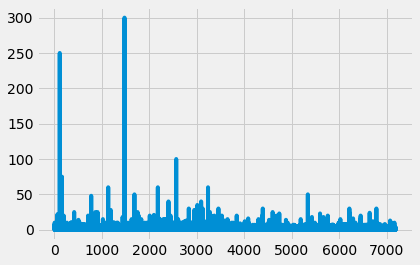

In [136]:
plt.plot(x)

In [137]:
free_apps = data[(x==0.00)]

paid_apps  = data[(x>0)]

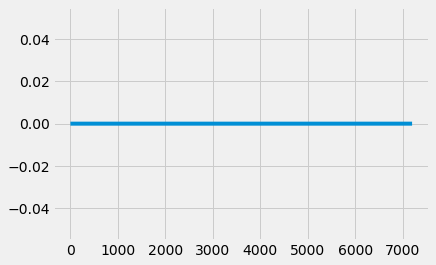

In [138]:
plt.plot(free_apps['price'])

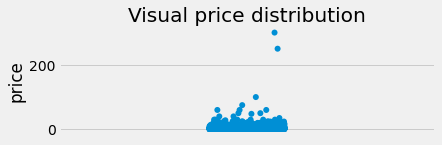

In [139]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6,4))

plt.subplot(2,1,2)
plt.title('Visual price distribution')
sns.stripplot(data=paid_apps,y='price',jitter= True,orient = 'h' ,size=6)
plt.show()

In [140]:
Top_Apps=paid_apps[paid_apps.price>50][['track_name','price','prime_genre','user_rating']]
Top_Apps

,track_name,price,prime_genre,user_rating
115,Proloquo2Go - Symbol-based AAC,249.99,Education,4.0
162,NAVIGON Europe,74.99,Navigation,3.5
1136,Articulation Station Pro,59.99,Education,4.5
1479,LAMP Words For Life,299.99,Education,4.0
2181,Articulation Test Center Pro,59.99,Education,4.5
2568,KNFB Reader,99.99,Productivity,4.5
3238,FineScanner Pro - PDF Document Scanner App + OCR,59.99,Business,4.0


In [160]:
def visualizer(x, y, plot_type, title, xlabel, ylabel, figsize=(15,8)):
    plt.figure(figsize=figsize)
    
    if plot_type == "bar":  
        sns.barplot(x=x, y=y)
    elif plot_type == "count":  
        sns.countplot(x)
   
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.yticks(fontsize=13)
    
    plt.show()

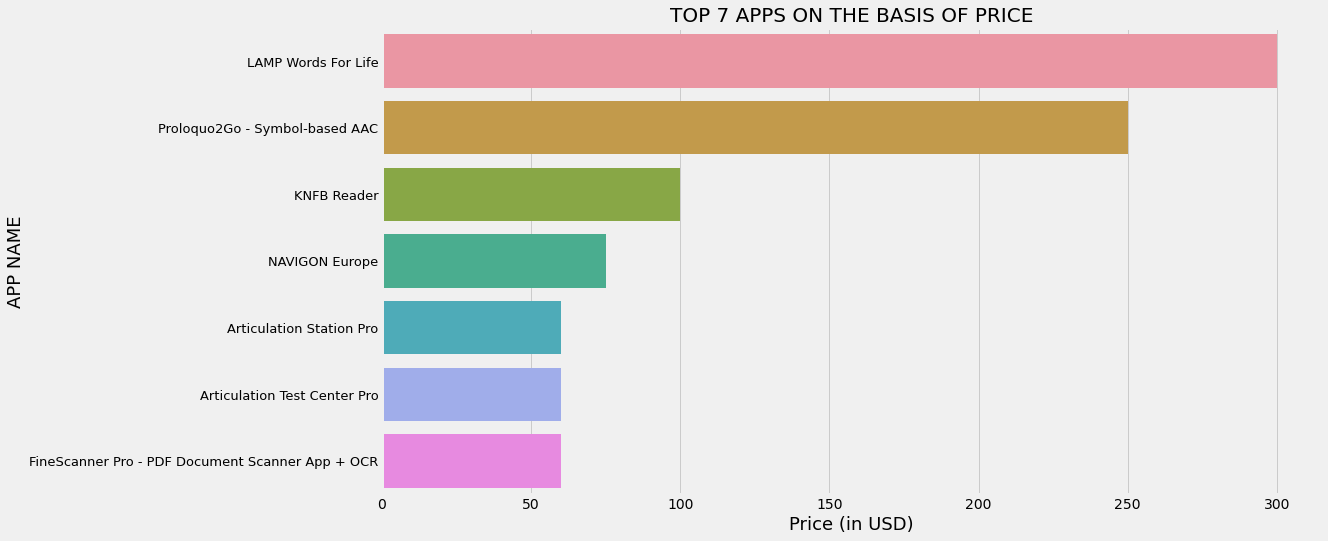

In [161]:
Top_Apps = Top_Apps.sort_values('price', ascending=False)

visualizer(Top_Apps.price,Top_Apps.track_name, "bar", "TOP 7 APPS ON THE BASIS OF PRICE","Price (in USD)","APP NAME")

In [154]:
new_data_cate = data.groupby([data.prime_genre])[['id']].count().reset_index().sort_values('id' ,ascending = False)
new_data_cate.columns = ['prime_genre','# of Apps']
new_data_cate.head()

,prime_genre,# of Apps
7,Games,3862
4,Entertainment,535
3,Education,453
14,Photo & Video,349
21,Utilities,248


<AxesSubplot:xlabel='# of Apps', ylabel='prime_genre'>

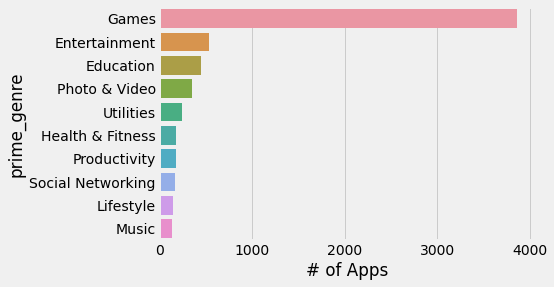

In [155]:
sns.barplot(y = 'prime_genre',x = '# of Apps', data=new_data_cate.head(10))

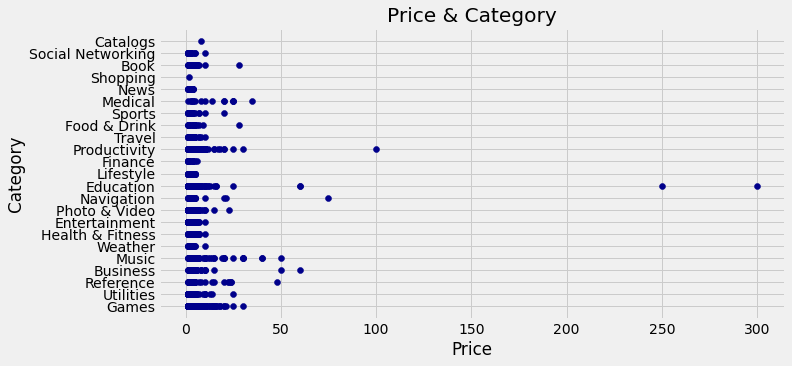

In [156]:
plt.figure(figsize=(10,5))
plt.scatter(y=paid_apps.prime_genre ,x=paid_apps.price,c='DarkBlue')
plt.title('Price & Category')
plt.xlabel('Price')
plt.ylabel('Category')
plt.show()

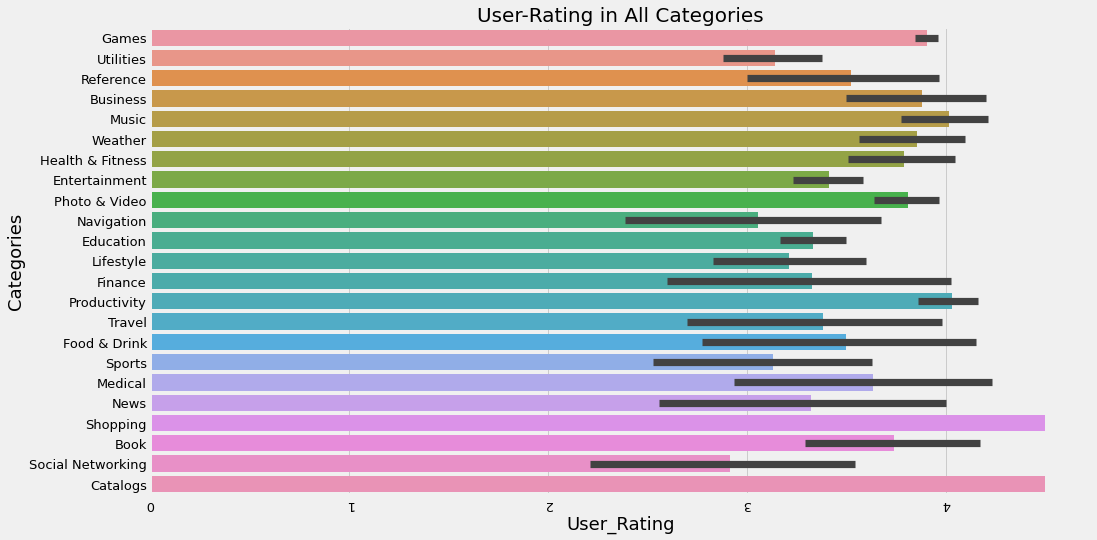

In [157]:
visualizer(paid_apps['user_rating'],paid_apps.prime_genre, "bar", "User-Rating in All Categories","User_Rating","Categories")

In [157]:
import pandas as pd
data=pd.read_excel(r'googleplaystore.xlsx')

df = data.copy()
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0.0,Everyone,Art & Design,2018-01-07 00:00:00,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15 00:00:00,2.0.0,4.0.3 and up
2,"U Launcher Lite ‰ÛÒ FREE Live Cool Themes, Hid...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0.0,Everyone,Art & Design,2018-08-01 00:00:00,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0.0,Teen,Art & Design,2018-06-08 00:00:00,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0.0,Everyone,Art & Design;Creativity,2018-06-20 00:00:00,1.1,4.4 and up


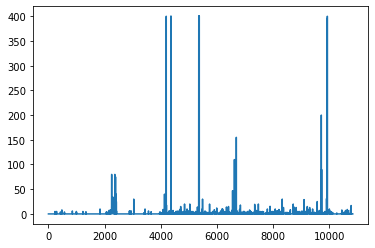

In [158]:

plt.plot(df.Price)


In [160]:
free_apps = df[(df.Price==0.00)]

paid_apps  = df[df.Price>0.00]


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
234,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6.8M,"100,000+",Paid,4.99,Everyone,Business,2018-03-25 00:00:00,1.5.2,4.0 and up
235,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39M,"100,000+",Paid,4.99,Everyone,Business,2017-04-11 00:00:00,3.4.6,3.0 and up
290,TurboScan: scan documents and receipts in PDF,BUSINESS,4.7,11442,6.8M,"100,000+",Paid,4.99,Everyone,Business,2018-03-25 00:00:00,1.5.2,4.0 and up
291,Tiny Scanner Pro: PDF Doc Scan,BUSINESS,4.8,10295,39M,"100,000+",Paid,4.99,Everyone,Business,2017-04-11 00:00:00,3.4.6,3.0 and up
427,Puffin Browser Pro,COMMUNICATION,4.0,18247,Varies with device,"100,000+",Paid,3.99,Everyone,Communication,2018-07-05 00:00:00,7.5.3.20547,4.1 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,FP VoiceBot,FAMILY,NaN,17,157k,100+,Paid,0.99,Mature 17+,Entertainment,2015-11-25 00:00:00,1.2,2.1 and up
10760,Fast Tract Diet,HEALTH_AND_FITNESS,4.4,35,2.4M,"1,000+",Paid,7.99,Everyone,Health & Fitness,2018-08-08 00:00:00,1.9.3,4.2 and up
10782,Trine 2: Complete Story,GAME,3.8,252,11M,"10,000+",Paid,16.99,Teen,Action,2015-02-27 00:00:00,2.22,5.0 and up
10785,"sugar, sugar",FAMILY,4.2,1405,9.5M,"10,000+",Paid,1.20,Everyone,Puzzle,2018-06-05 00:00:00,2.7,2.3 and up


In [165]:
Top_Apps=paid_apps[paid_apps.Price>50][['App','Price','Genres','Rating']]
Top_Apps

,App,Price,Genres,Rating
2253,Vargo Anesthesia Mega App,79.99,Medical,4.6
2365,Vargo Anesthesia Mega App,79.99,Medical,4.6
2390,Language Therapy: Aphasia,74.99,Medical,NaN
4197,most expensive app (H),399.99,Entertainment,4.3
4362,?ÙÕ? I'm rich,399.99,Lifestyle,3.8
4367,I'm Rich - Trump Edition,400.00,Lifestyle,3.6
5351,I am rich,399.99,Lifestyle,3.8
5354,I am Rich Plus,399.99,Entertainment,4.0
5355,I am rich VIP,299.99,Lifestyle,3.8
5356,I Am Rich Premium,399.99,Finance,4.1


In [167]:
def visualizer(x, y, plot_type, title, xlabel, ylabel, figsize=(15,8)):
    plt.figure(figsize=figsize)
    
    if plot_type == "bar":  
        sns.barplot(x=x, y=y)
    elif plot_type == "count":  
        sns.countplot(x)
   
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.yticks(fontsize=13)
    
    plt.show()

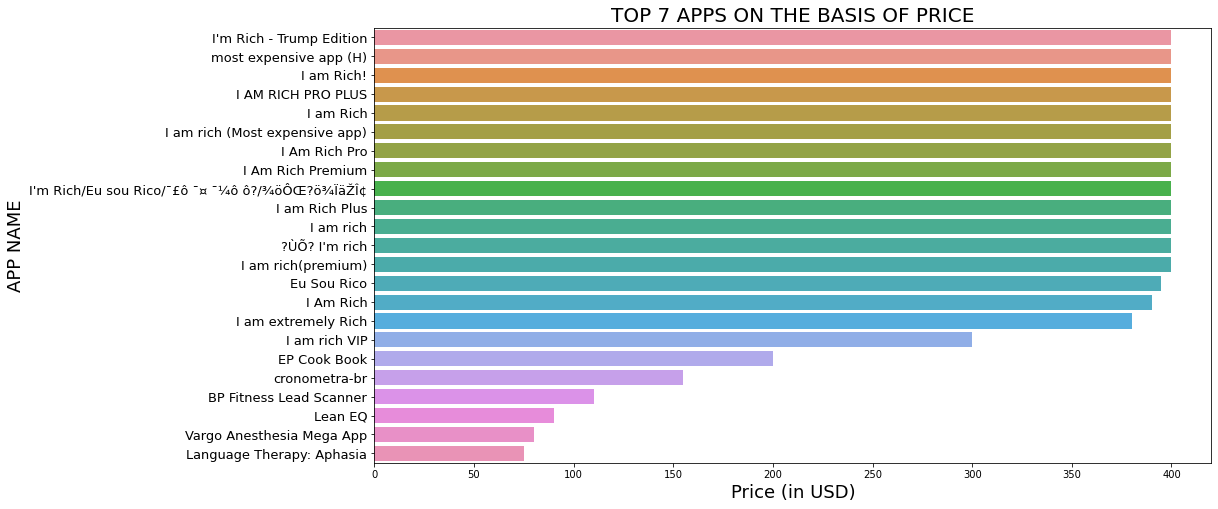

In [170]:
Top_Apps = Top_Apps.sort_values('Price', ascending=False)

visualizer(Top_Apps.Price,Top_Apps.App, "bar", "TOP 7 APPS ON THE BASIS OF PRICE","Price (in USD)","APP NAME")

In [174]:
new_data_cate = data.groupby([data.Genres])[['App']].count().reset_index().sort_values('App' ,ascending = False)
new_data_cate.columns = ['Genres','# of Apps']
new_data_cate.head()

,Genres,# of Apps
109,Tools,842
53,Entertainment,623
40,Education,549
72,Medical,463
23,Business,460


<AxesSubplot:xlabel='# of Apps', ylabel='Genres'>

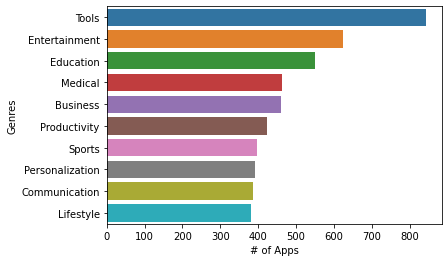

In [175]:
sns.barplot(y = 'Genres',x = '# of Apps', data=new_data_cate.head(10))

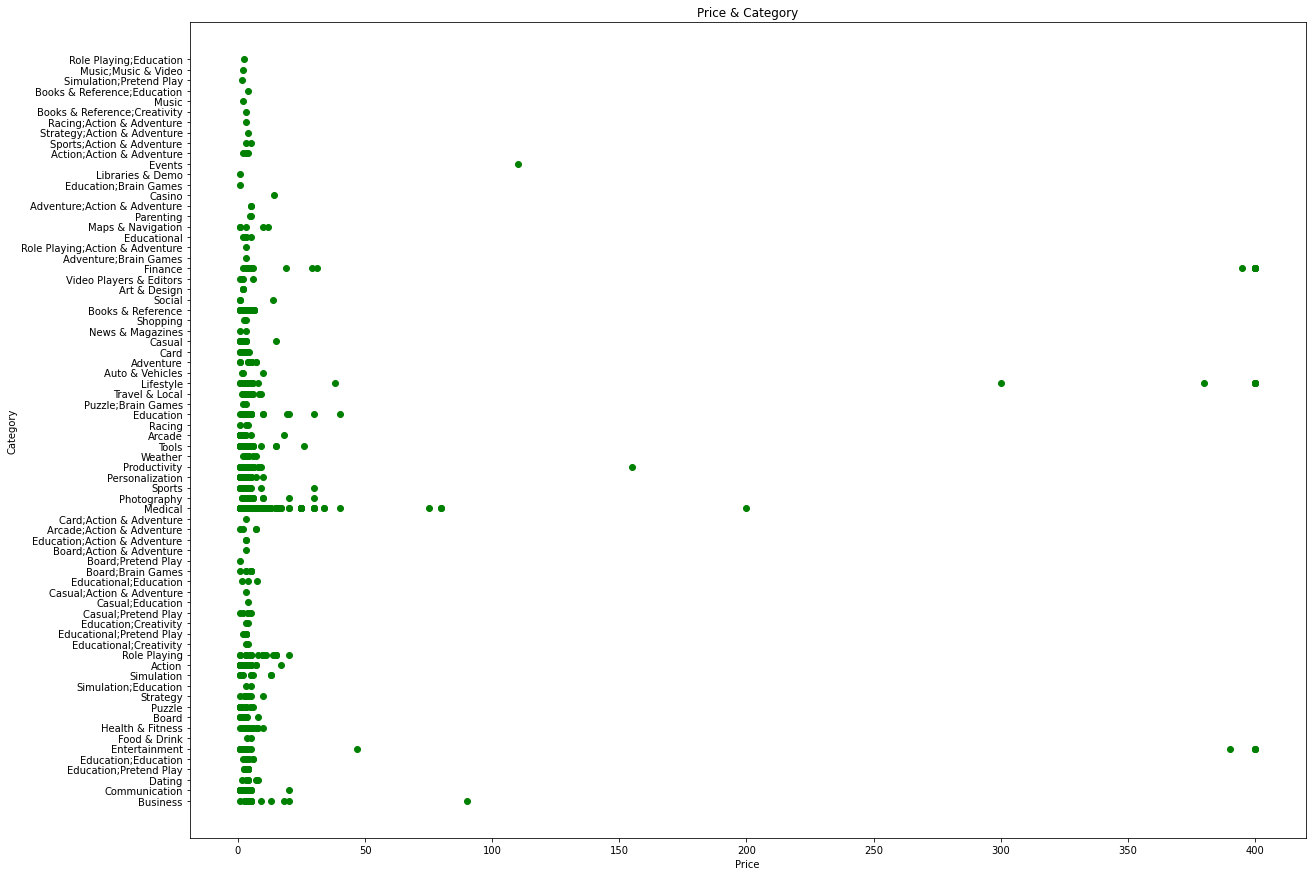

In [181]:
plt.figure(figsize=(20,15))
plt.scatter(y=paid_apps['Genres'] ,x=paid_apps['Price'],c='green')
plt.title('Price & Category')
plt.xlabel('Price')
plt.ylabel('Category')
plt.show()

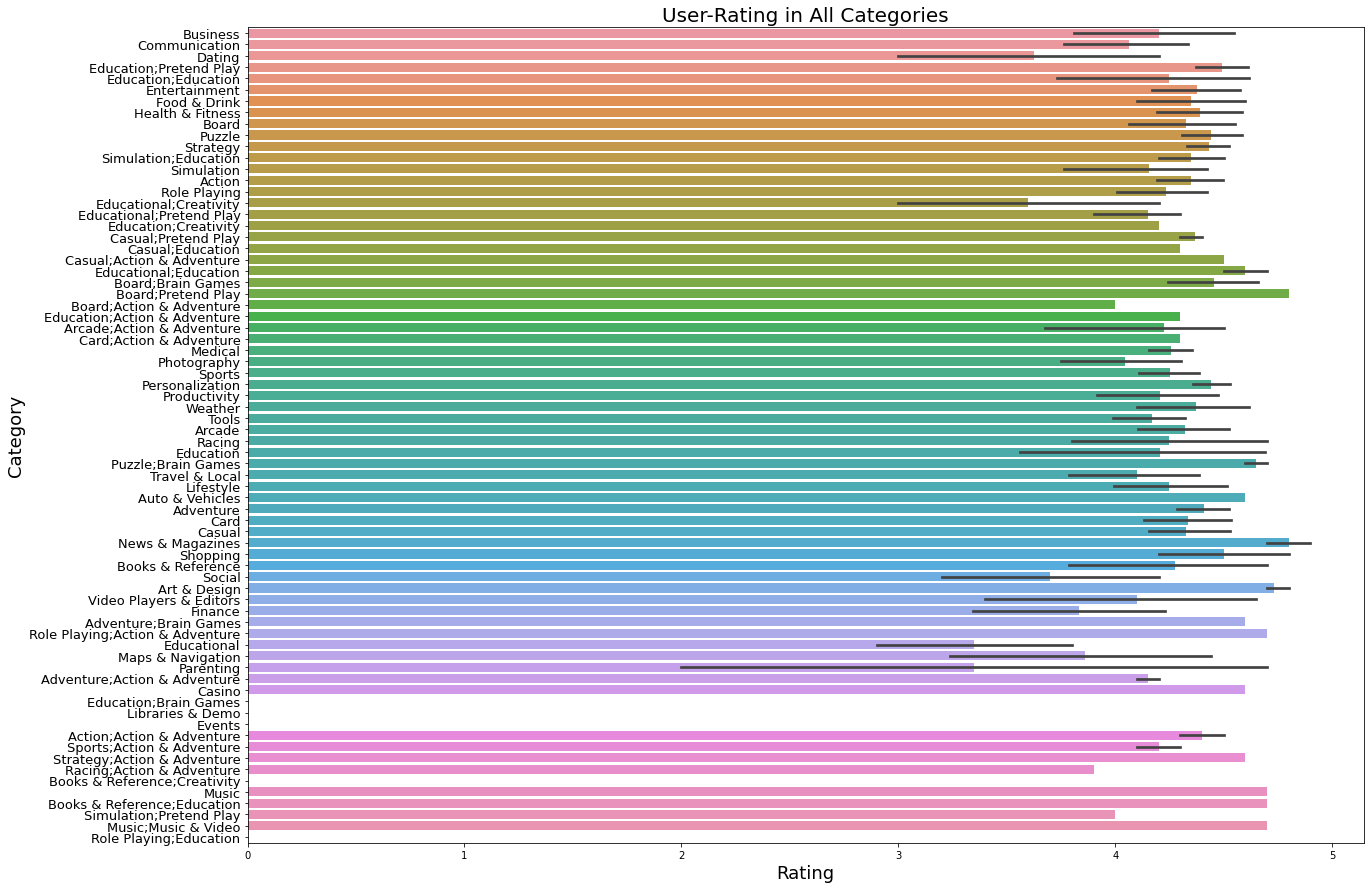

In [183]:
visualizer(paid_apps['Rating'],paid_apps["Genres"], "bar", "User-Rating in All Categories","Rating","Category",figsize=(20,15))